In [17]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from keras import Model
from tensorflow.keras.layers import Input,Activation,Add, MaxPooling2D, MaxPooling1D, Flatten, Dense, Conv1D, Dropout
from tensorflow import keras
from tensorflow.keras import layers, models
from skimage import color
from skimage import filters
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


In [43]:
# Choose the label type
Labeltype = 'gender'

In [44]:
# Import image labels and paths to dataframe
mypath = "../data/raw/CroppedImages/"
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns).astype({'age': 'int', 'gender': 'int', 'race': 'int'})

# Convert age to appropriate labels
filedf['age']=np.where((filedf.age<3), 0, filedf.age)
filedf['age']=np.where(((filedf.age>=3) & (filedf.age<6)), 1, filedf.age)
filedf['age']=np.where(((filedf.age>=6) & (filedf.age<9)), 2, filedf.age)
filedf['age']=np.where(((filedf.age>=9) & (filedf.age<12)), 3, filedf.age)
filedf['age']=np.where(((filedf.age>=12) & (filedf.age<21)), 4, filedf.age)
filedf['age']=np.where(((filedf.age>=21) & (filedf.age<36)), 5, filedf.age)
filedf['age']=np.where(((filedf.age>=36) & (filedf.age<51)), 6, filedf.age)
filedf['age']=np.where(((filedf.age>=51) & (filedf.age<80)), 7, filedf.age)
filedf['age']=np.where((filedf.age>=80), 8, filedf.age)

dfx = filedf.loc[:,'file']
dfy = filedf.loc[:,Labeltype]

# Get Train/Test
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

# Get Train/Test/Validation dataset 0.25 * 8 = 0.2
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Encode training labels and initialize random over sampler
yencoded = LabelEncoder().fit_transform(y_train_2)
oversample = RandomOverSampler()

# Over sample until training classes are balanced
X_train_balanced, y_train_balanced = oversample.fit_resample(np.array(X_train_2).reshape(-1,1), yencoded)

# Of all classes, proportionally sample 10000
dxy = {'file': X_train_balanced.reshape(len(X_train_balanced)), 'label': y_train_balanced}
dfbalanced = pd.DataFrame(data = dxy)
balancedsamples = int(5000/len(set(dfbalanced.loc[:,'label'])))
dfbalancedsubset = dfbalanced.groupby('label', group_keys=False).apply(lambda x: x.sample(balancedsamples)).sample(frac=1)

# Count and print balanced classes
counter = Counter(y_train_balanced)
for k,v in counter.items():
    per = v / len(y_train_balanced) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

# Count and print balanced classes subsets (Total should be 10000)
counter = Counter(dfbalancedsubset.loc[:,'label'])
for k,v in counter.items():
    per = v / len(dfbalancedsubset.loc[:,'label']) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=1, n=7443 (50.000%)
Class=0, n=7443 (50.000%)
Class=1, n=2500 (50.000%)
Class=0, n=2500 (50.000%)


In [45]:
# Get training images
train_img_container = []
for i in dfbalancedsubset.loc[:,'file']:
    img = cv2.imread(i)
    train_img_container.append(img)
train_img_container = np.array(train_img_container)

# Get validation images
validation_img_container = []
for i in X_val:
    img = cv2.imread(i)
    validation_img_container.append(img)
validation_img_container = np.array(validation_img_container)

# Get testing images
test_img_container = []
for i in X_test:
    img = cv2.imread(i)
    test_img_container.append(img)
test_img_container = np.array(test_img_container)


In [32]:
# Expand array dimensions to 4D so that they may be used as inputs
X_train_expand = train_img_container.reshape(len(train_img_container),200*200*3)
X_val_expand = validation_img_container.reshape(len(validation_img_container),200*200*3)
X_test_expand = test_img_container.reshape(len(test_img_container),200*200*3)

In [46]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(X_train_expand, dfbalancedsubset.loc[:,'label'])
ypred = neigh.predict(X_val_expand)
ypredtest = neigh.predict(X_test_expand)

In [38]:
ypredtrain = neigh.predict(X_train_expand)


In [14]:
print("Training Accuracy")
print(accuracy_score(ypredtrain,dfbalancedsubset.loc[:,'label']))

Training Accuracy
0.9971971971971972


In [11]:
print("Validation Accuracy")
print(accuracy_score(ypred,y_val))

Validation Accuracy
0.2710398650073824


In [47]:
print("Testing Accuracy")
print(accuracy_score(ypredtest,y_test))

Testing Accuracy
0.48892638683821976


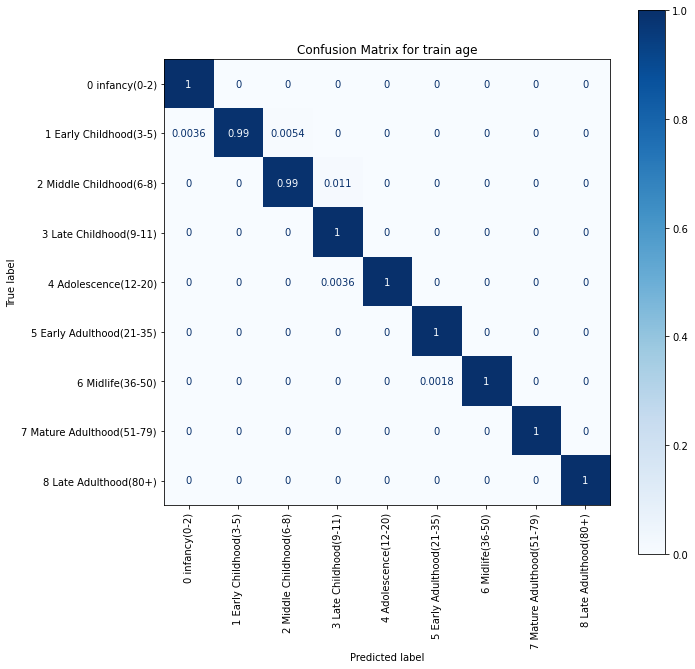

In [26]:
labels = ['0 infancy(0-2)','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
cm = confusion_matrix(ypredtrain,dfbalancedsubset.loc[:,'label'],normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for train age')
plt.xticks(rotation = 90)
plt.show()

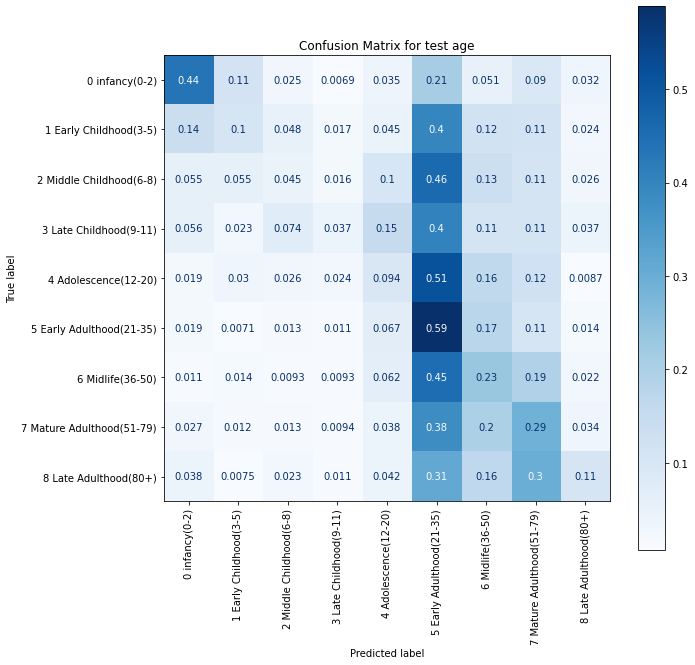

In [28]:
labels = ['0 infancy(0-2','1 Early Childhood(3-5)','2 Middle Childhood(6-8)','3 Late Childhood(9-11)','4 Adolescence(12-20)'
          ,'5 Early Adulthood(21-35)','6 Midlife(36-50)','7 Mature Adulthood(51-79)','8 Late Adulthood(80+)']
cm = confusion_matrix(ypredtest,y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for test age')
plt.xticks(rotation = 90)

plt.show()

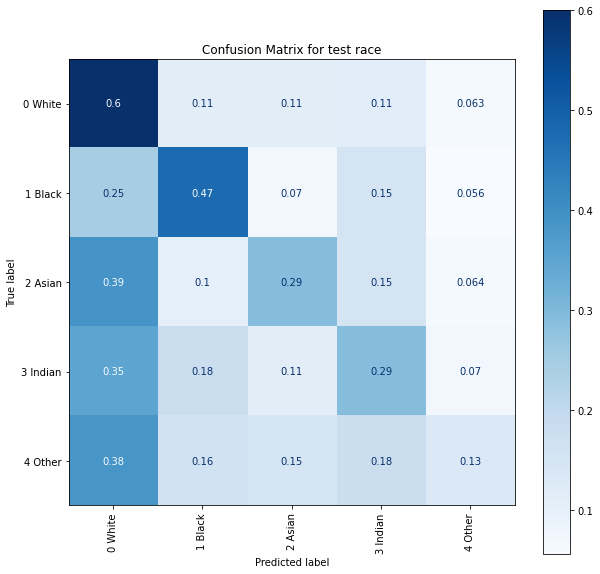

In [42]:
labels = ['0 White','1 Black','2 Asian','3 Indian','4 Other']
cm = confusion_matrix(ypredtest,y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for test race')
plt.xticks(rotation = 90)

plt.show()

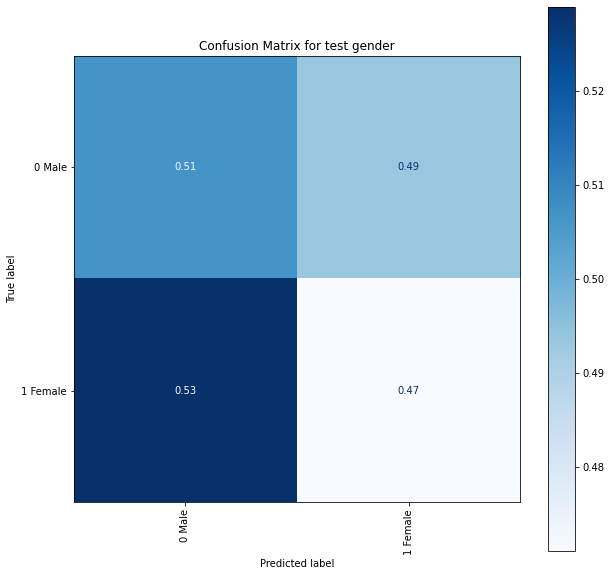

In [48]:
labels = ['0 Male','1 Female']
cm = confusion_matrix(ypredtest,y_test,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
plt.title('Confusion Matrix for test gender')
plt.xticks(rotation = 90)

plt.show()